<a href="https://colab.research.google.com/github/timhalter/PA-Addee/blob/main/Updated_PA_Addee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [15]:
import pandas as pd
import numpy as np

import plotly.express as px

import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from keras import Sequential
from keras.layers import Dense,LSTM,Embedding
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import nltk
nltk.download('stopwords')

import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Load dataset**

In [6]:
url = 'https://raw.githubusercontent.com/timhalter/PA-Addee/main/children_books.csv'
df = pd.read_csv(url,encoding='ISO-8859-1')
df.drop(['Author', 'Inerest_age'], axis=1, inplace=True)
df.rename(columns = {'Title':'title', 'Desc':'desc', 'Reading_age':'age'}, inplace = True)

df.head()

,title,desc,age
0,The Girl Who Drank the Moon,"Every year, the evil Protectorate offers a bab...",10-14
1,Time Between Us,Sixteen-year-old Anna is struggling to underst...,12+
2,Girl Out of Water,Lou Brown's swimming ambitions sank without tr...,10+
3,Captive,Robyn is scared. Ever since the attempted assa...,13
4,The School of Music,Welcome to the School of Music. In charge is M...,10+


In [7]:
df['age'].value_counts().sort_index()


10+                                     525
10-12                                    85
10-14                                    91
11+                                     448
12+                                     708
13                                       87
13+                                     533
14+                                     173
8+                                      267
9+                                      352
Name: age, dtype: int64

**Preprocessing**

In [8]:
def get_min_age(sir):
    if sir.find('-') != -1:
        return int(sir.split('-')[0])
    else:
        return int(sir.replace('+',' ').split(' ')[0])

def get_max_age(sir):
    if sir.find('-') != -1:
        return int(sir.split('-')[1])
    elif sir.find('+') != -1:
        sp = sir.replace(' ', '')
        sp = sir.replace('+', '')
        return int(sp)
    else:
        return 99

In [9]:
#Preprocessing And Feature Engineering
df.names = df.title.str.lower()
df.desc = df.desc.str.lower()
df['Min_Age'] = df.age.apply(get_min_age)
df['Max_Age'] = df.age.apply(get_max_age)
df['Title Nb Words'] = df.names.apply(lambda x: len(re.sub(' +', ' ', x).strip().split(' ')))
df['Title Avg Word Length'] = df.names.apply(lambda x: np.mean(np.array([len(word) for word in (re.sub(' +', ' ', x).strip().split(' '))])))
df['Range Length'] = df.Max_Age - df.Min_Age
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



,title,desc,age,Min_Age,Max_Age,Title Nb Words,Title Avg Word Length,Range Length
0,The Girl Who Drank the Moon,"every year, the evil protectorate offers a bab...",10-14,10,14,6,3.666667,4
1,Time Between Us,sixteen-year-old anna is struggling to underst...,12+,12,12,3,4.333333,0
2,Girl Out of Water,lou brown's swimming ambitions sank without tr...,10+,10,10,4,3.500000,0
3,Captive,robyn is scared. ever since the attempted assa...,13,13,99,1,7.000000,86
4,The School of Music,welcome to the school of music. in charge is m...,10+,10,10,4,4.000000,0
...,...,...,...,...,...,...,...,...
3264,Spy for the Queen of Scots,"beautiful young aristocrat ginette, known as j...",12+,12,12,6,3.500000,0
3265,Jimmy Corrigan:,this extraordinary graphic novel is so obvious...,14+,14,14,2,7.000000,0
3266,The Martian Girl,"following on from the brilliant lost on mars, ...",10+,10,10,3,4.666667,0
3267,Buffalo Soldier,plantation slave charley smith is eleven when ...,11+,11,11,2,7.000000,0


In [10]:
df['Min_Age'].value_counts() / len(df['Min_Age'])

12    0.216580
10    0.214439
13    0.189660
11    0.137045
9     0.107678
8     0.081676
14    0.052921
Name: Min_Age, dtype: float64


In [11]:
df['Max_Age'].value_counts() / len(df['Max_Age'])

12    0.242582
13    0.163047
10    0.160600
11    0.137045
9     0.107678
8     0.081676
14    0.080759
99    0.026614
Name: Max_Age, dtype: float64

**Process Text**

In [13]:
def process_text(text):
    
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    
    # Split on whitespace
    text = text.split()
    
    # Join on whitespace, but only the words that are not stop words
    text = ' '.join([word for word in text if word not in stopwords.words('english')])
    
    return text

In [17]:
names = df['title'].copy().apply(process_text)
descriptions = df['desc'].copy().apply(process_text)

labels = df['Min_Age'].copy()

In [37]:
labels

0       10
1       12
2       10
3       13
4       10
        ..
3264    12
3265    14
3266    10
3267    11
3268    12
Name: Min_Age, Length: 3269, dtype: int64

**Tokenize**

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([names, descriptions]))

names = tokenizer.texts_to_sequences(names)
descriptions = tokenizer.texts_to_sequences(descriptions)

In [19]:
vocab_length = len(tokenizer.word_index) + 1
max_name_length = np.max(list(map(lambda name: len(name), names)))
max_desc_length = np.max(list(map(lambda desc: len(desc), descriptions)))

print("Max name length:", max_name_length)
print("Max description length:", max_desc_length)
print("Vocabulary length:", vocab_length)

Max name length: 5
Max description length: 303
Vocabulary length: 2204


In [22]:
names = pad_sequences(names, maxlen=max_name_length, padding='post')
descriptions = pad_sequences(descriptions, maxlen=max_desc_length, padding='post')

print("Shape:", names.shape)
names

Shape: (3269, 5)


array([[  17,   18,  181,  693,  314],
       [  10, 1283,  187,    0,    0],
       [  18,  445, 1284,    0,    0],
       ...,
       [  17,  162,   18,    0,    0],
       [ 935,  936,    0,    0,    0],
       [1537,    0,    0,    0,    0]], dtype=int32)

In [23]:

print("Shape:", descriptions.shape)
descriptions

Shape: (3269, 303)


array([[ 105,   12,  165, ...,    0,    0,    0],
       [1288,   12,    5, ...,    0,    0,    0],
       [ 455, 1301, 1302, ...,    0,    0,    0],
       ...,
       [ 637,  157,  619, ...,    0,    0,    0],
       [1243, 1244,  199, ...,    0,    0,    0],
       [ 288, 1796, 1797, ...,    0,    0,    0]], dtype=int32)

**Train/Test split**

In [26]:
names_train, names_test, descriptions_train, descriptions_test, labels_train, labels_test = \
train_test_split(names, descriptions, labels, train_size=0.7, random_state=100)



In [27]:
name_dim = 64

name_input = tf.keras.Input(shape=(max_name_length,), name="name_input")

name_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=name_dim,
    input_length=max_name_length,
    name="name_embedding"
)(name_input)

name_flatten = tf.keras.layers.Flatten(name="name_flatten")(name_embedding)

In [28]:
desc_dim = 64

desc_input = tf.keras.Input(shape=(max_desc_length,), name="desc_input")

desc_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=desc_dim,
    input_length=max_desc_length,
    name="desc_embedding"
)(desc_input)

gru_layer = tf.keras.layers.GRU(
    units=256,
    return_sequences=True,
    name="gru_layer"
)(desc_embedding)

desc_flatten = tf.keras.layers.Flatten(name="desc_flatten")(gru_layer)

In [29]:
concat = tf.keras.layers.concatenate([name_flatten, desc_flatten], name="concatenate")

output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(concat)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc_input (InputLayer)         [(None, 303)]        0                                            
__________________________________________________________________________________________________
name_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
desc_embedding (Embedding)      (None, 303, 64)      141056      desc_input[0][0]                 
__________________________________________________________________________________________________
name_embedding (Embedding)      (None, 5, 64)        141056      name_input[0][0]                 
______________________________________________________________________________________________

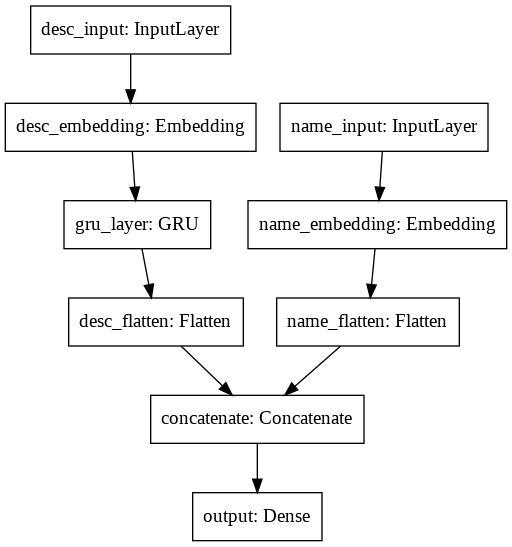

In [30]:
model = tf.keras.Model(inputs=[name_input, desc_input], outputs=output)

print(model.summary())
tf.keras.utils.plot_model(model)

**Training**

In [31]:
batch_size = 32
epochs = 14

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    [names_train, descriptions_train],
    labels_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/14
58/58 [==============================] - 46s 738ms/step - loss: -20964.2539 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: -47406.2695 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/14
58/58 [==============================] - 42s 730ms/step - loss: -71538.3672 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: -96381.3438 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/14
58/58 [==============================] - 42s 729ms/step - loss: -119793.8047 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: -143842.4062 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 4/14
58/58 [==============================] - 42s 728ms/step - loss: -167124.9688 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: -190795.1250 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 5/14
58/58 [==============================] - 42s 730ms/step - loss: -214063.0625 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: -237393.2344 - val_accuracy: 0.0000e+00 - val_auc: 

In [34]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'x': "epoch", 'y': "loss"},
    title="Loss Over Time"
)

fig.show()

In [33]:
results = model.evaluate([names_test, descriptions_test], labels_test)

print("Accuracy:", results[1])
print(" ROC AUC:", results[2])

31/31 [==============================] - 6s 198ms/step - loss: -655887.1250 - accuracy: 0.0000e+00 - auc: 0.0000e+00


[-655887.125, 0.0, 0.0]